# YOLOv8 model for Underwater Object Detection

This is a replication of the model/architecture purposed in **A lightweight YOLOv8 integrating FasterNet for real-time underwater object detection**. The paper can be found at [this link](https://www.researchgate.net/publication/378873018_A_lightweight_YOLOv8_integrating_FasterNet_for_real-time_underwater_object_detection). 

## Enviornment Setup

- Should create venv. 
- Setup: python3 -m venv myenv
- To activate: source myenv/bin/activate 
- To deactivate: deactivate
- Connect notebook to a kernel and choose myenv. 

- Navigate to ultralytics folder and do pip install -e .

## Dataset Setup

Using the RUOD dataset:

- Download the dataset from [here](https://github.com/xiaoDetection/RUOD?tab=readme-ov-file). I recommend using the Google option.
- Create ./data folder within the model. (Like this: ./uw-yolov8/data)
- Place the downloaded .zip file inside the data-folder
- Then unzip it manually or running code below:

In [1]:
import zipfile
import os

zip_path = "data/RUOD.zip"
extract_dir = "data/RUOD/"

# Make sure the target directory exists
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ RUOD dataset extracted to:", os.path.abspath(extract_dir))


✅ RUOD dataset extracted to: /Users/henrik/kode/SP/uw_yolov8/data/RUOD


### Make labels on right format. COCO -> YOLO

In [2]:
import json, os
from pathlib import Path
from collections import defaultdict

ROOT = Path("data/RUOD")
IMAGES = ROOT/"RUOD_pic"
ANN    = ROOT/"RUOD_ANN"

def clip(v, lo, hi): return max(lo, min(hi, v))

def convert(split, coco_json):
    labels_dir = ROOT/"labels"/split
    labels_dir.mkdir(parents=True, exist_ok=True)
    coco = json.loads(Path(coco_json).read_text())

    id2img = {im["id"]: im for im in coco["images"]}
    byimg = defaultdict(list)
    for a in coco["annotations"]:
        if a.get("iscrowd",0)==1 or a.get("ignore",0)==1:
            continue
        byimg[a["image_id"]].append(a)

    # build contiguous class map from categories order
    sorted_cats = sorted(coco["categories"], key=lambda c: c["id"])
    cat2idx = {c["id"]: i for i,c in enumerate(sorted_cats)}

    written = 0
    for img_id, img in id2img.items():
        img_path = IMAGES/split/img["file_name"]
        if not img_path.exists():
            continue
        W,H = img["width"], img["height"]
        lines=[]
        for ann in byimg.get(img_id, []):
            x,y,w,h = ann["bbox"]
            x = clip(x,0,W); y = clip(y,0,H)
            w = clip(w,0,W-x); h = clip(h,0,H-y)
            if w<=0 or h<=0: continue
            xc = (x+w/2)/W; yc=(y+h/2)/H
            wn = w/W; hn=h/H
            cls = cat2idx[ann["category_id"]]
            lines.append(f"{cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")
        if lines:
            (labels_dir/(Path(img["file_name"]).stem+".txt")).write_text("\n".join(lines))
            written+=1
    print(f"{split}: wrote labels for {written} images")

convert("train", ANN/"instances_train.json")
convert("test",  ANN/"instances_test.json")


train: wrote labels for 9800 images
test: wrote labels for 4200 images


### Check Paths for data are ok

In [3]:
from pathlib import Path
import os, shutil

# Paths
ROOT = Path.cwd()              # notebook root
DATA = ROOT / "data" / "RUOD"

# 🪄 Rename RUOD_pic → images if needed
old = DATA / "RUOD_pic"
new = DATA / "images"
if old.exists() and not new.exists():
    shutil.move(str(old), str(new))
    print("✅ Renamed RUOD_pic → images")

# Define paths
IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA / "images" / "test"
LABELS_TRAIN = DATA / "labels" / "train"
LABELS_VAL   = DATA / "labels" / "test"

# Check everything exists
for p in [IMAGES_TRAIN, IMAGES_VAL, LABELS_TRAIN, LABELS_VAL]:
    print(p, "✅ OK" if p.exists() else "❌ MISSING")


✅ Renamed RUOD_pic → images
/Users/henrik/kode/SP/uw_yolov8/data/RUOD/images/train ✅ OK
/Users/henrik/kode/SP/uw_yolov8/data/RUOD/images/test ✅ OK
/Users/henrik/kode/SP/uw_yolov8/data/RUOD/labels/train ✅ OK
/Users/henrik/kode/SP/uw_yolov8/data/RUOD/labels/test ✅ OK


### Write yaml config file

In [4]:
from pathlib import Path
ROOT = Path.cwd()
DATA = ROOT / "data" / "RUOD"

IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA / "images" / "test"        # or use a dedicated val split if you have one

dataset_yaml = f"""
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}
test:  {IMAGES_VAL.as_posix()}

# RUOD has 10 classes
names:
  - holothurian
  - echinus
  - scallop
  - starfish
  - fish
  - coral
  - diver
  - cuttlefish
  - turtle
  - jellyfish
"""
(DATA / "ruod.yaml").write_text(dataset_yaml)
print("Wrote:", DATA / "ruod.yaml")


Wrote: /Users/henrik/kode/SP/uw_yolov8/data/RUOD/ruod.yaml


### Now lets vizualise some data:


In [ ]:
# If these are not installed, run these lines:
# pip install opencv-python
# pip install matplotlib

  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 87.9 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 90.9 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
Note: you may need to restart the kernel to use updated packages.


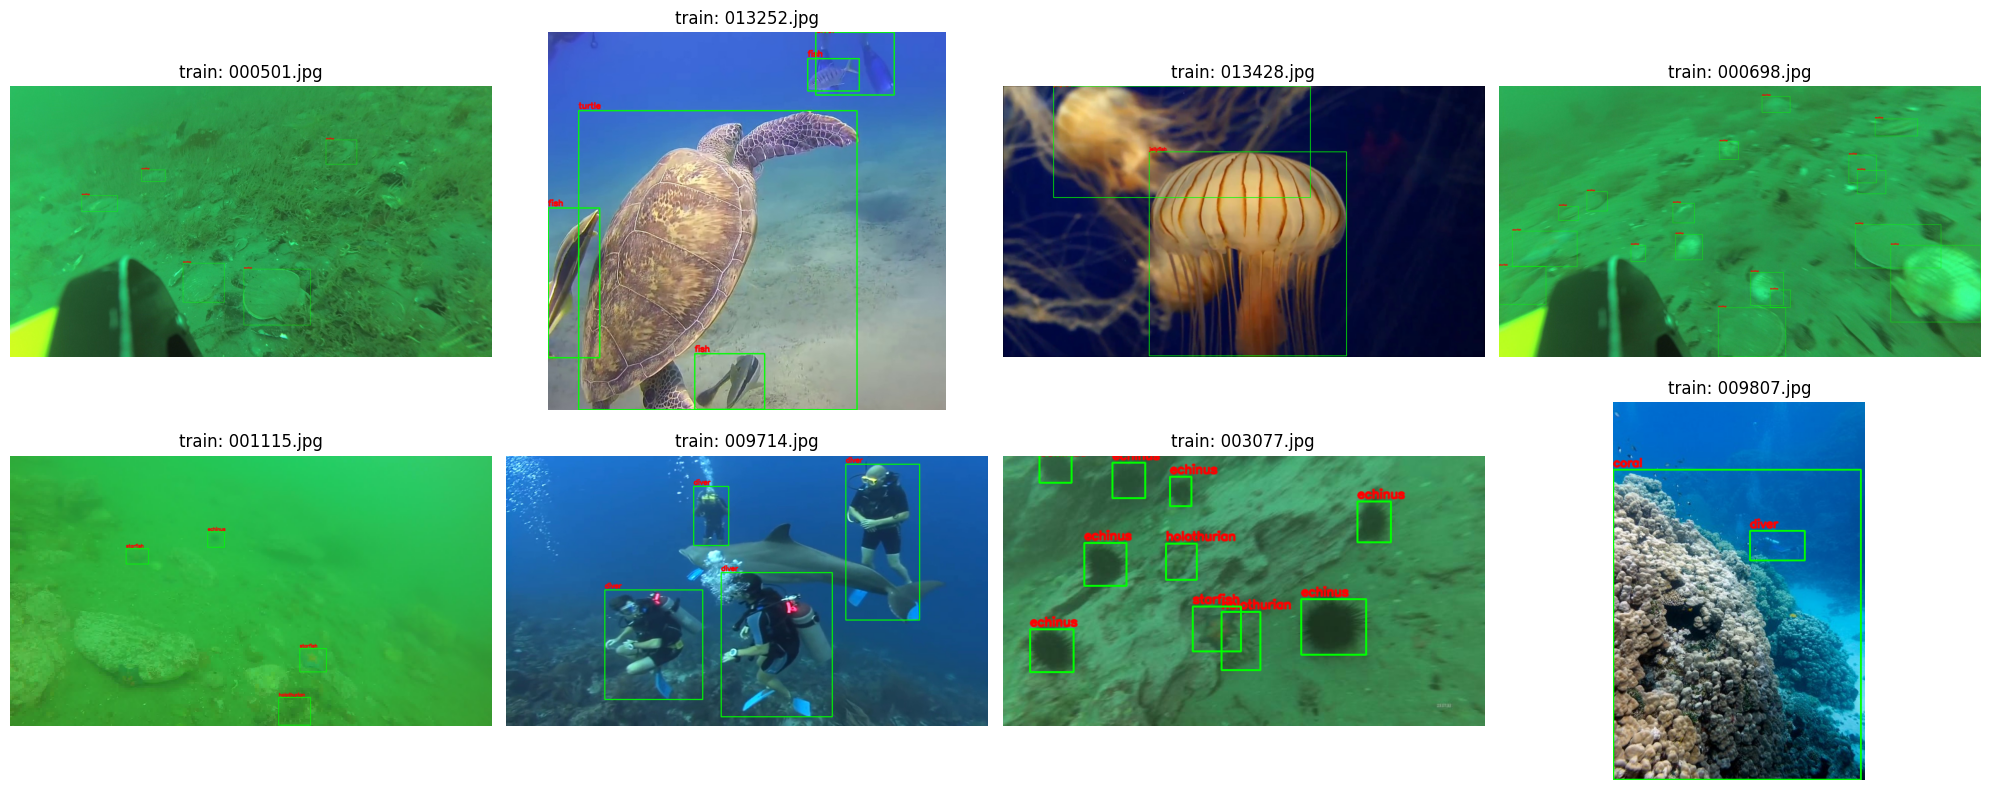

In [6]:
import os, math, random, re
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# ---------------- config ----------------
DATA_ROOT = Path("data/RUOD")
IMG_ROOT  = DATA_ROOT / "images"
LAB_ROOT  = DATA_ROOT / "labels"

SPLIT = "train"   # "train" or "test"
IMG_DIR = IMG_ROOT / SPLIT
LAB_DIR = LAB_ROOT / SPLIT

NUM_PICS = 8
COLS = 4

# RUOD class names (index must match IDs in .txt files)
RUOD_NAMES = [
    "holothurian","echinus","scallop","starfish","fish",
    "coral","diver","cuttlefish","turtle","jellyfish"
]
# ----------------------------------------

def find_images(folder: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def label_path_for(img_path: Path) -> Path:
    return LAB_DIR / (img_path.stem + ".txt")

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        # YOLO format: class cx cy w h (normalized 0..1)
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        color = (0,255,0)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2, cv2.LINE_AA)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# collect images that exist (optionally: require label file exists too)
all_imgs = find_images(IMG_DIR)
imgs_with_labels = [p for p in all_imgs if label_path_for(p).exists()]
pool = imgs_with_labels if imgs_with_labels else all_imgs

if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_ids = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_ids) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for idx, img_path in enumerate(sample_ids, 1):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    lab_path = label_path_for(img_path)
    vis = draw_yolo_labels(img_bgr, lab_path, RUOD_NAMES)

    plt.subplot(rows, COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SPLIT}: {img_path.name}")
plt.tight_layout(); plt.show()


# Building

Building (and training) of the model happens in [train.py](./train.py). The model is constructed by the [uw_yolov8.yaml](./models/uw_yolov8.yaml), that imports modules from custom blocks (see paragraph below).


### Adding custom blocks

I have added custom blocks to match the architecture as pruposed in the paper. For this to work I have first cloned the ultralytics repo.
- Head to [ultralytics](https://docs.ultralytics.com/guides/model-yaml-config/#source-code-modification) to see how to add custom blocks.
- Files that is modified: [block.py](../ultralytics/ultralytics/nn/modules/block.py) (classes: PConv, FasterBlock, GSConv and LC2f), [tasks.py](../ultralytics/ultralytics/nn/tasks.py) (added imports and updated parse_model() for special arguments), [__init__.py](../ultralytics/ultralytics/nn/modules/__init__.py) (exposing the modules).



### Is it an accurate replication??

Yes should be pretty good now. But a lot of paramters!?

# Training

- To train the model run the train.py script by doing: `python3 train.py`

### How I did training

- Using the IDUN computer at NTNU. 
    - Idun settings: 4 GPUS, any. 32 CPU cores, 64 GB RAM, 

- Loaded the pretrained yolov8s to make training faster. 


# Evaluation


### Get results
Here we get the actual results. Files are saved in runs_uwyolo folder.

In [8]:
from ultralytics import YOLO
model = YOLO("runs_uwyolo/fasternet_sgd300_4gpu_safe/weights/best.pt")
results = model.val(
    data="data/RUOD/ruod.yaml",
    imgsz=640,
    batch=1,
    iou=0.7,
    plots=True,
    project="runs_uwyolo",
    name="fasternet_eval",
    exist_ok=True
)
print(results)


Ultralytics 8.3.213 🚀 Python-3.12.4 torch-2.8.0 CPU (Apple M3)
uw_YOLOv8 summary: 292 layers, 35,972,654 parameters, 0 gradients, 101.8 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 469.6±590.2 MB/s, size: 173.5 KB)
val: Scanning /Users/henrik/kode/SP/uw_yolov8/data/RUOD/labels/test... 4200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4200/4200 5.9Kit/s 0.7s0.0s
val: New cache created: /Users/henrik/kode/SP/uw_yolov8/data/RUOD/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4200/4200 6.1it/s 11:24<0.3s
                   all       4200      22969      0.856      0.816      0.873      0.643
           holothurian        756       2382      0.853      0.772      0.841      0.535
               echinus        806       3425      0.891      0.853      0.913      0.556
               scallop        437       2373      0.834      0.756       0.84       0.54
              starfish        780       

### Show images in Notebook
This is for showing stuff in the notebook. The images are saved in the eval folder (these are not on git)

📈 BoxPR_curve.png


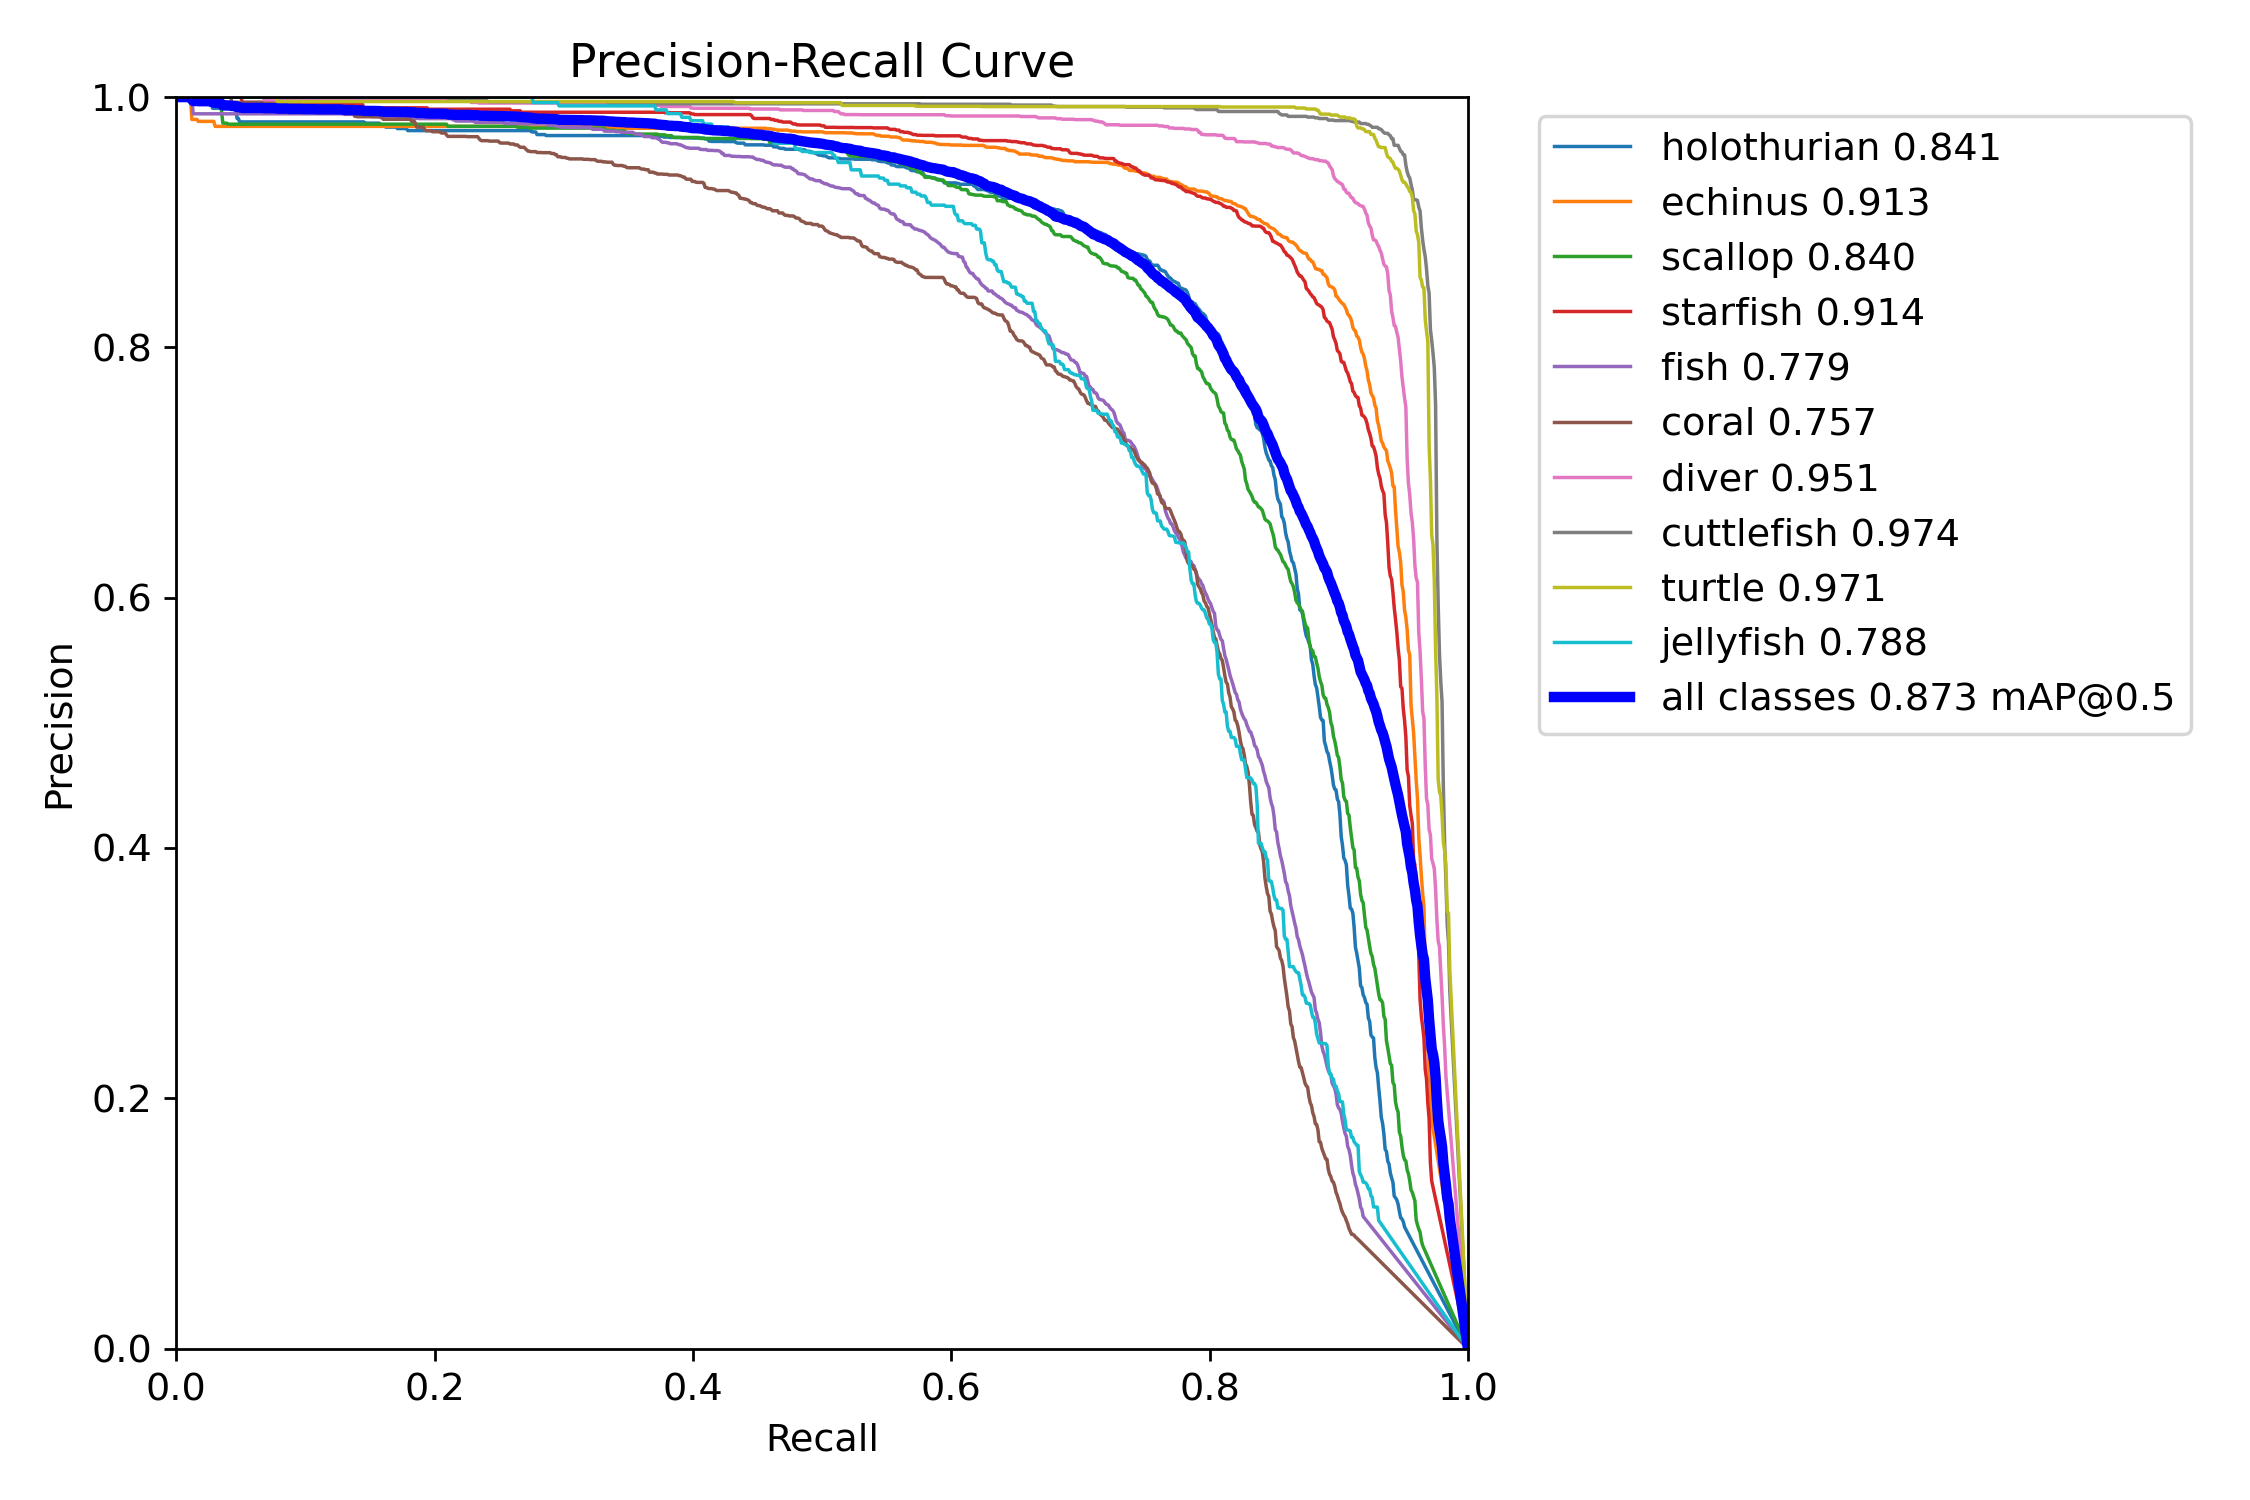

📈 BoxP_curve.png


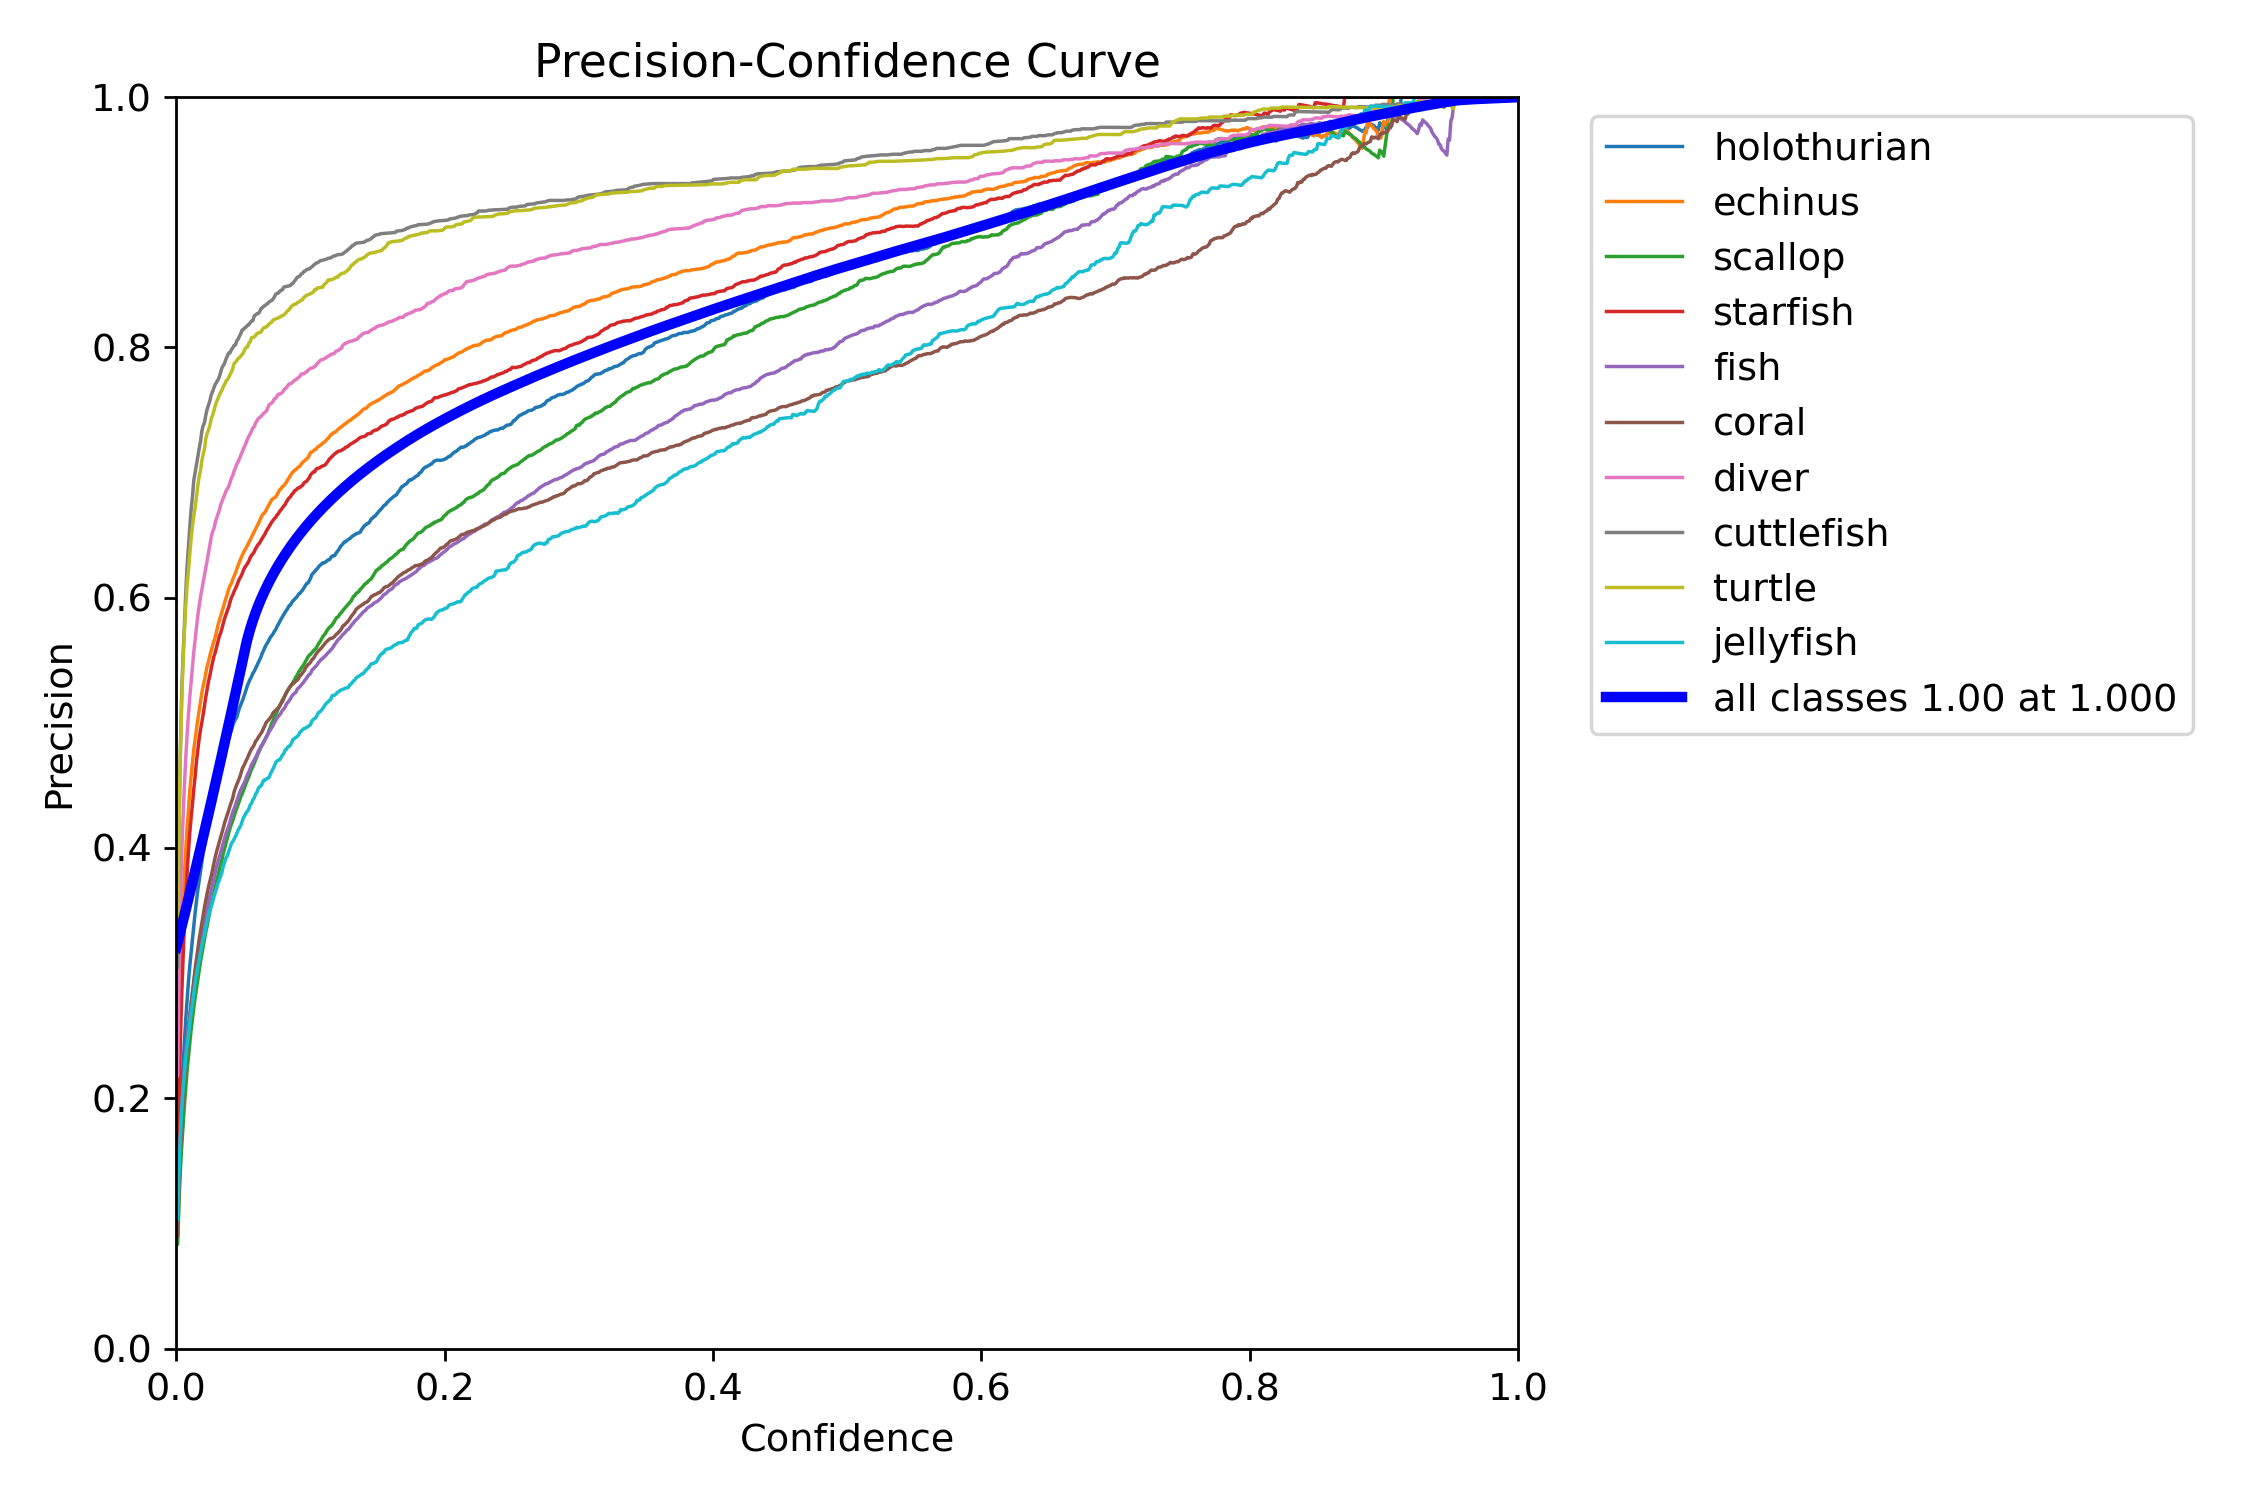

📈 BoxR_curve.png


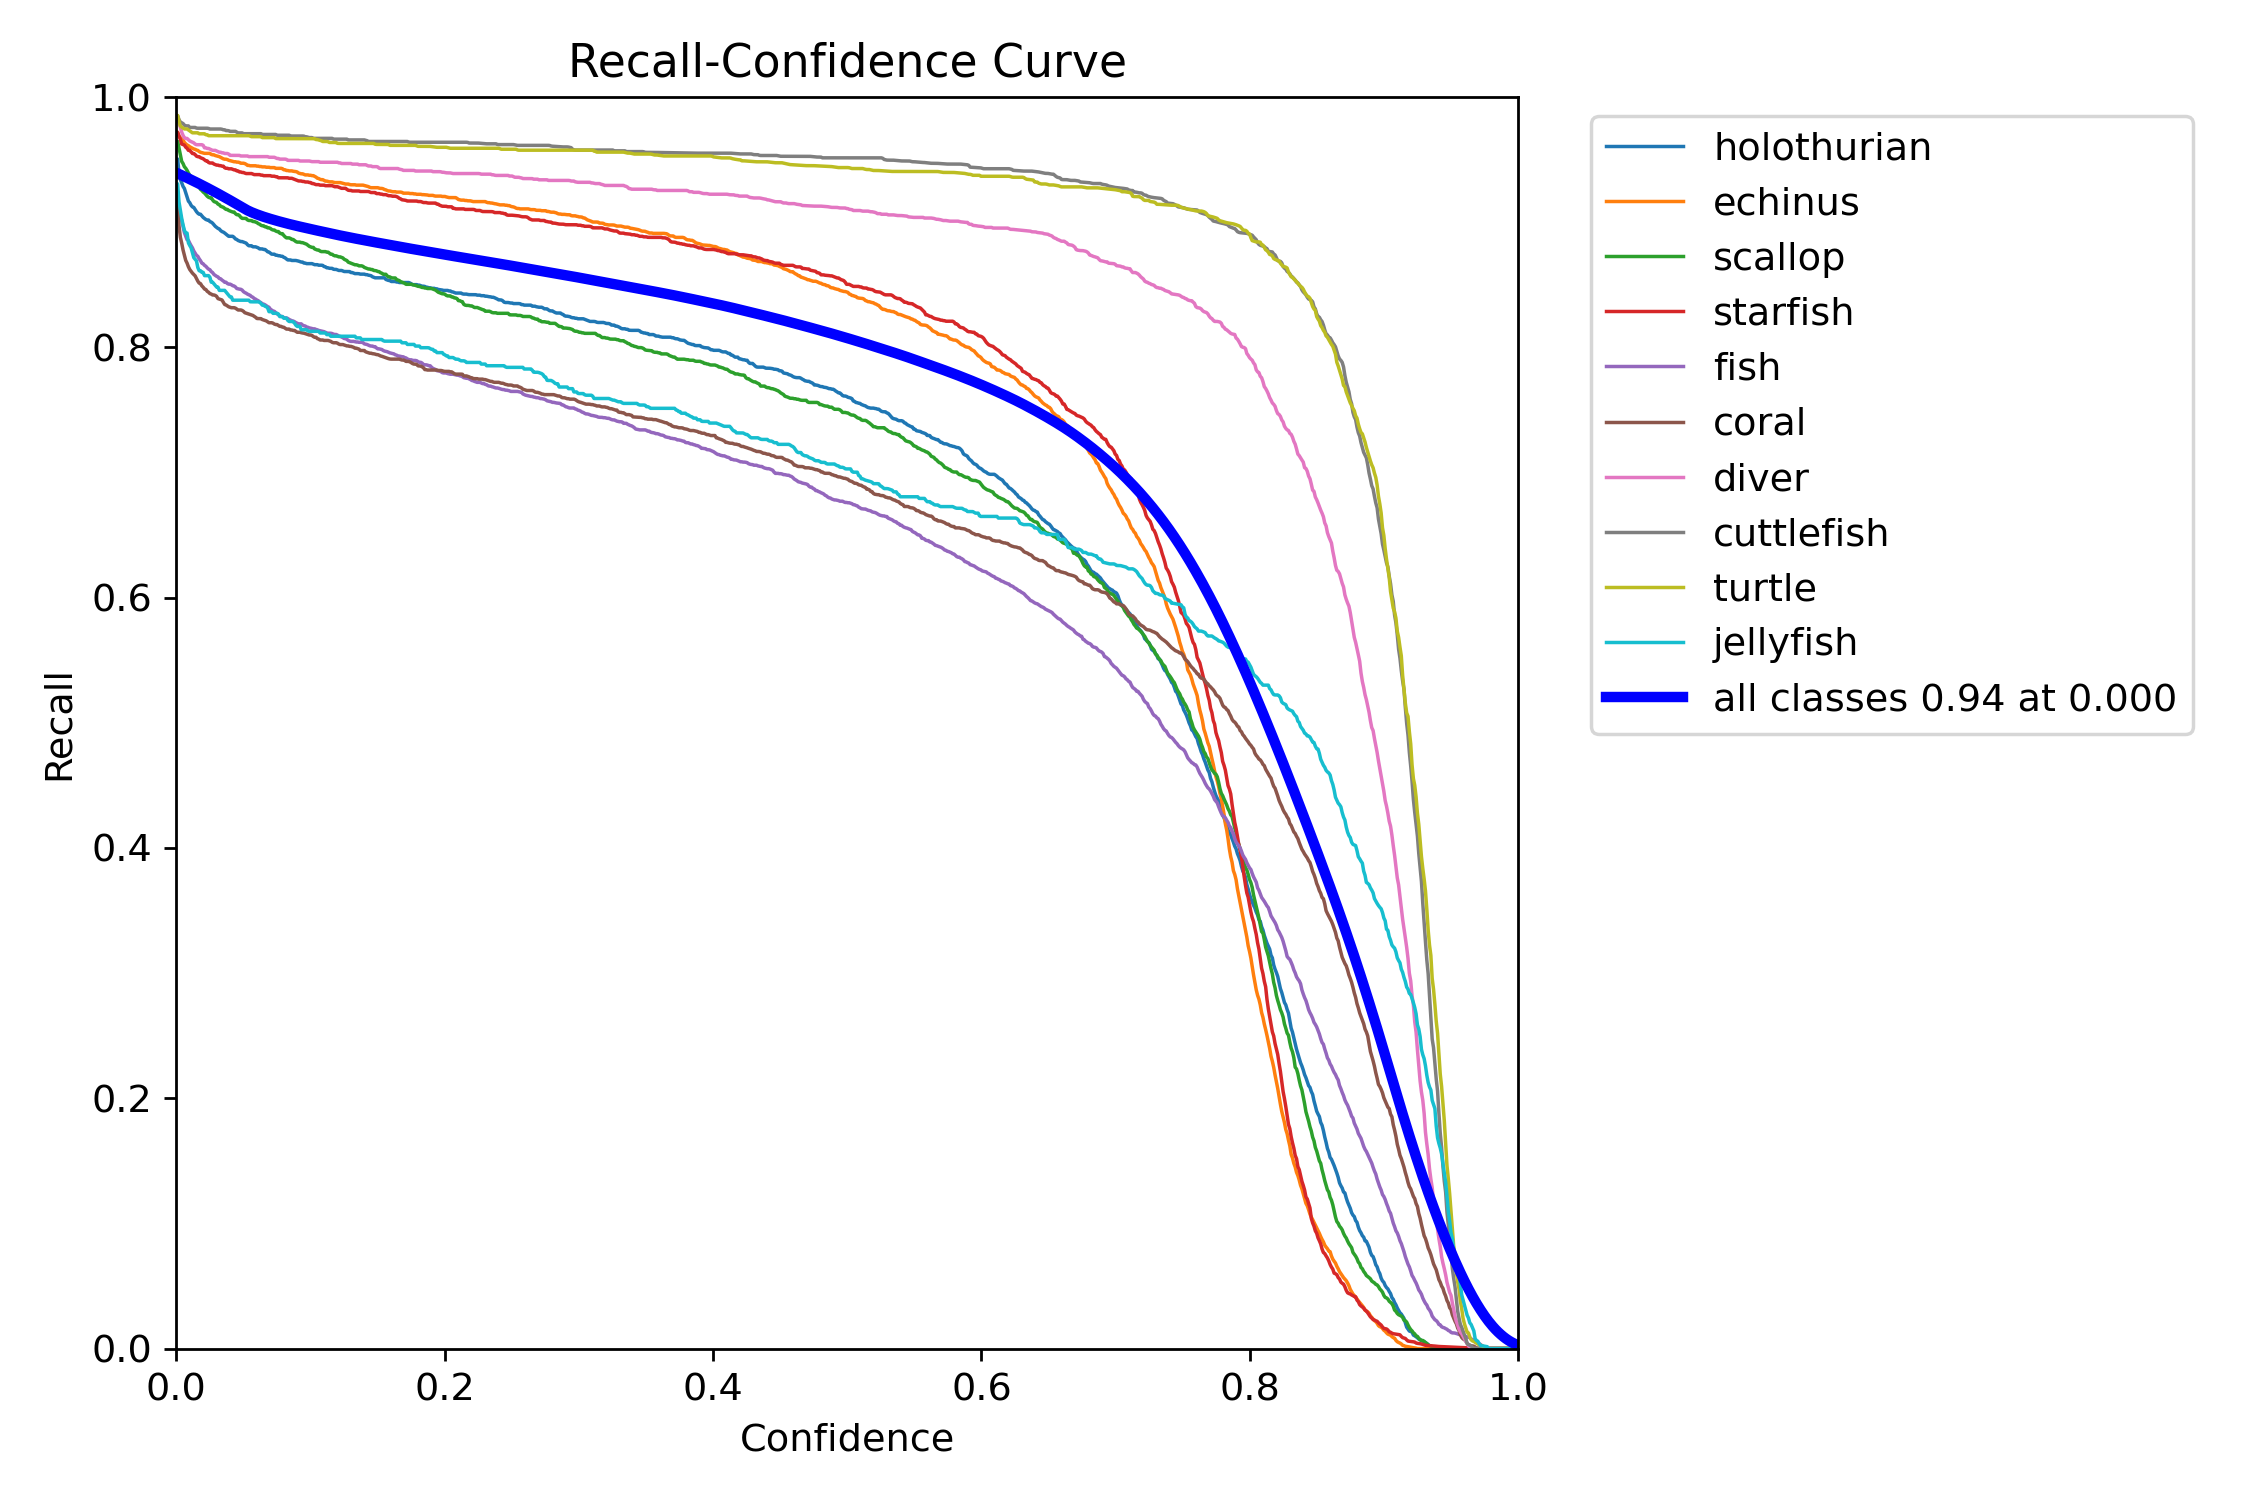

📈 BoxF1_curve.png


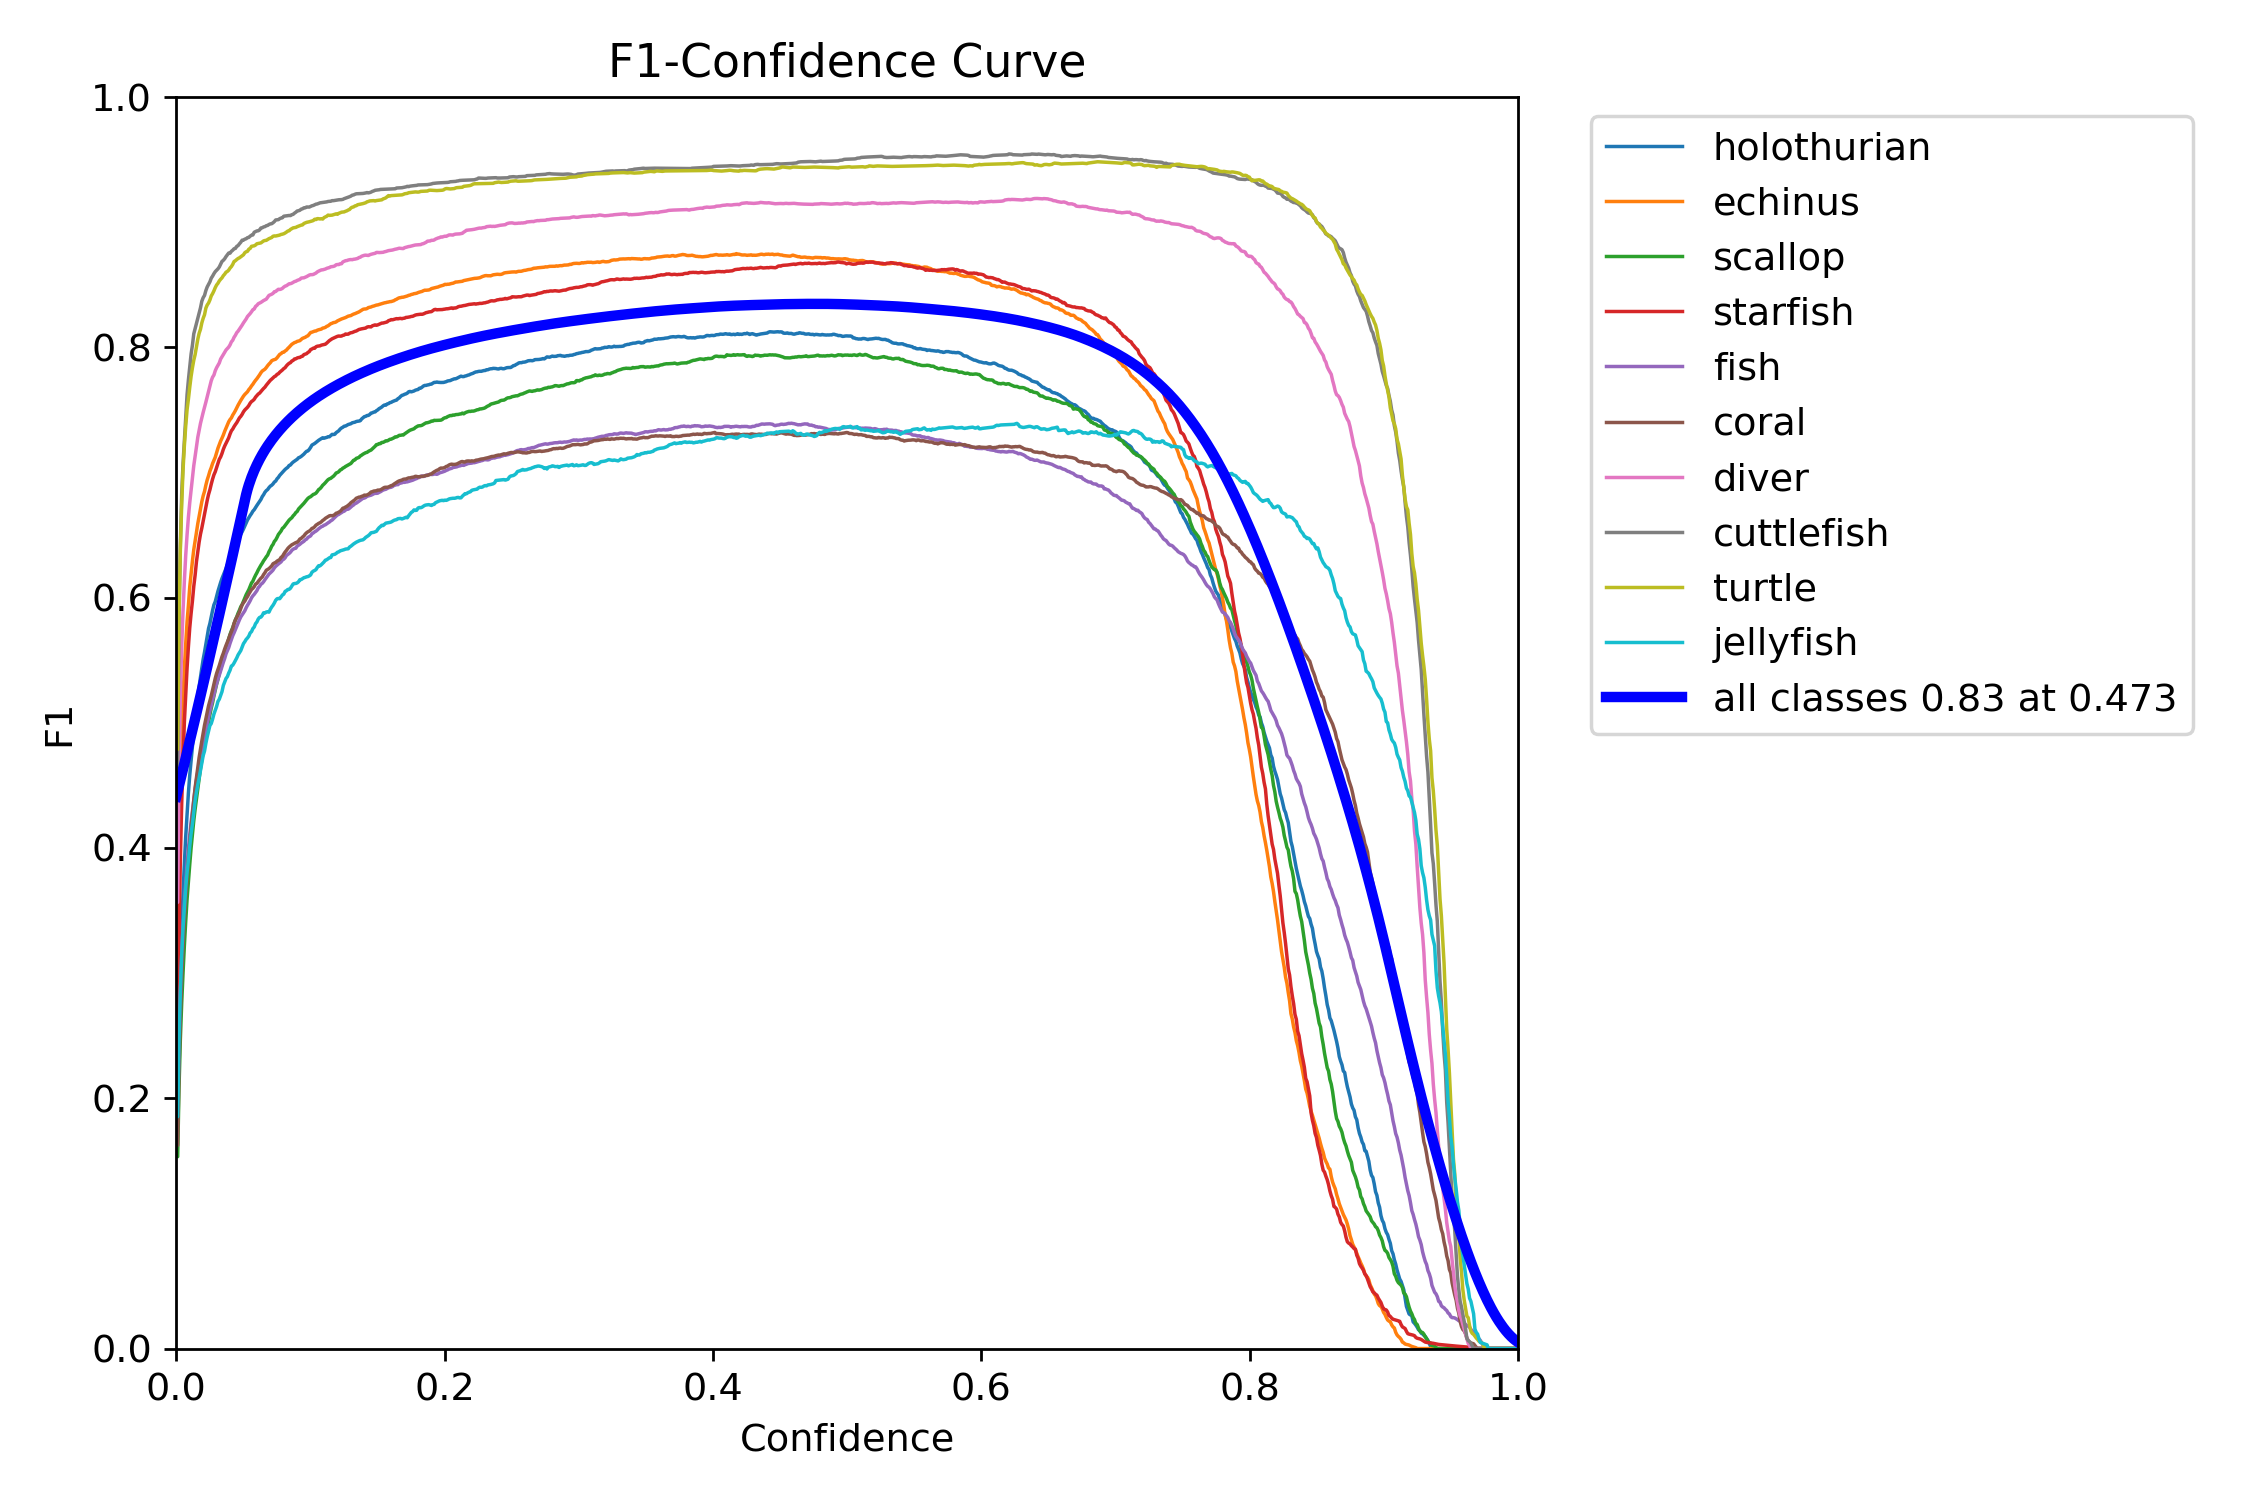

📈 confusion_matrix.png


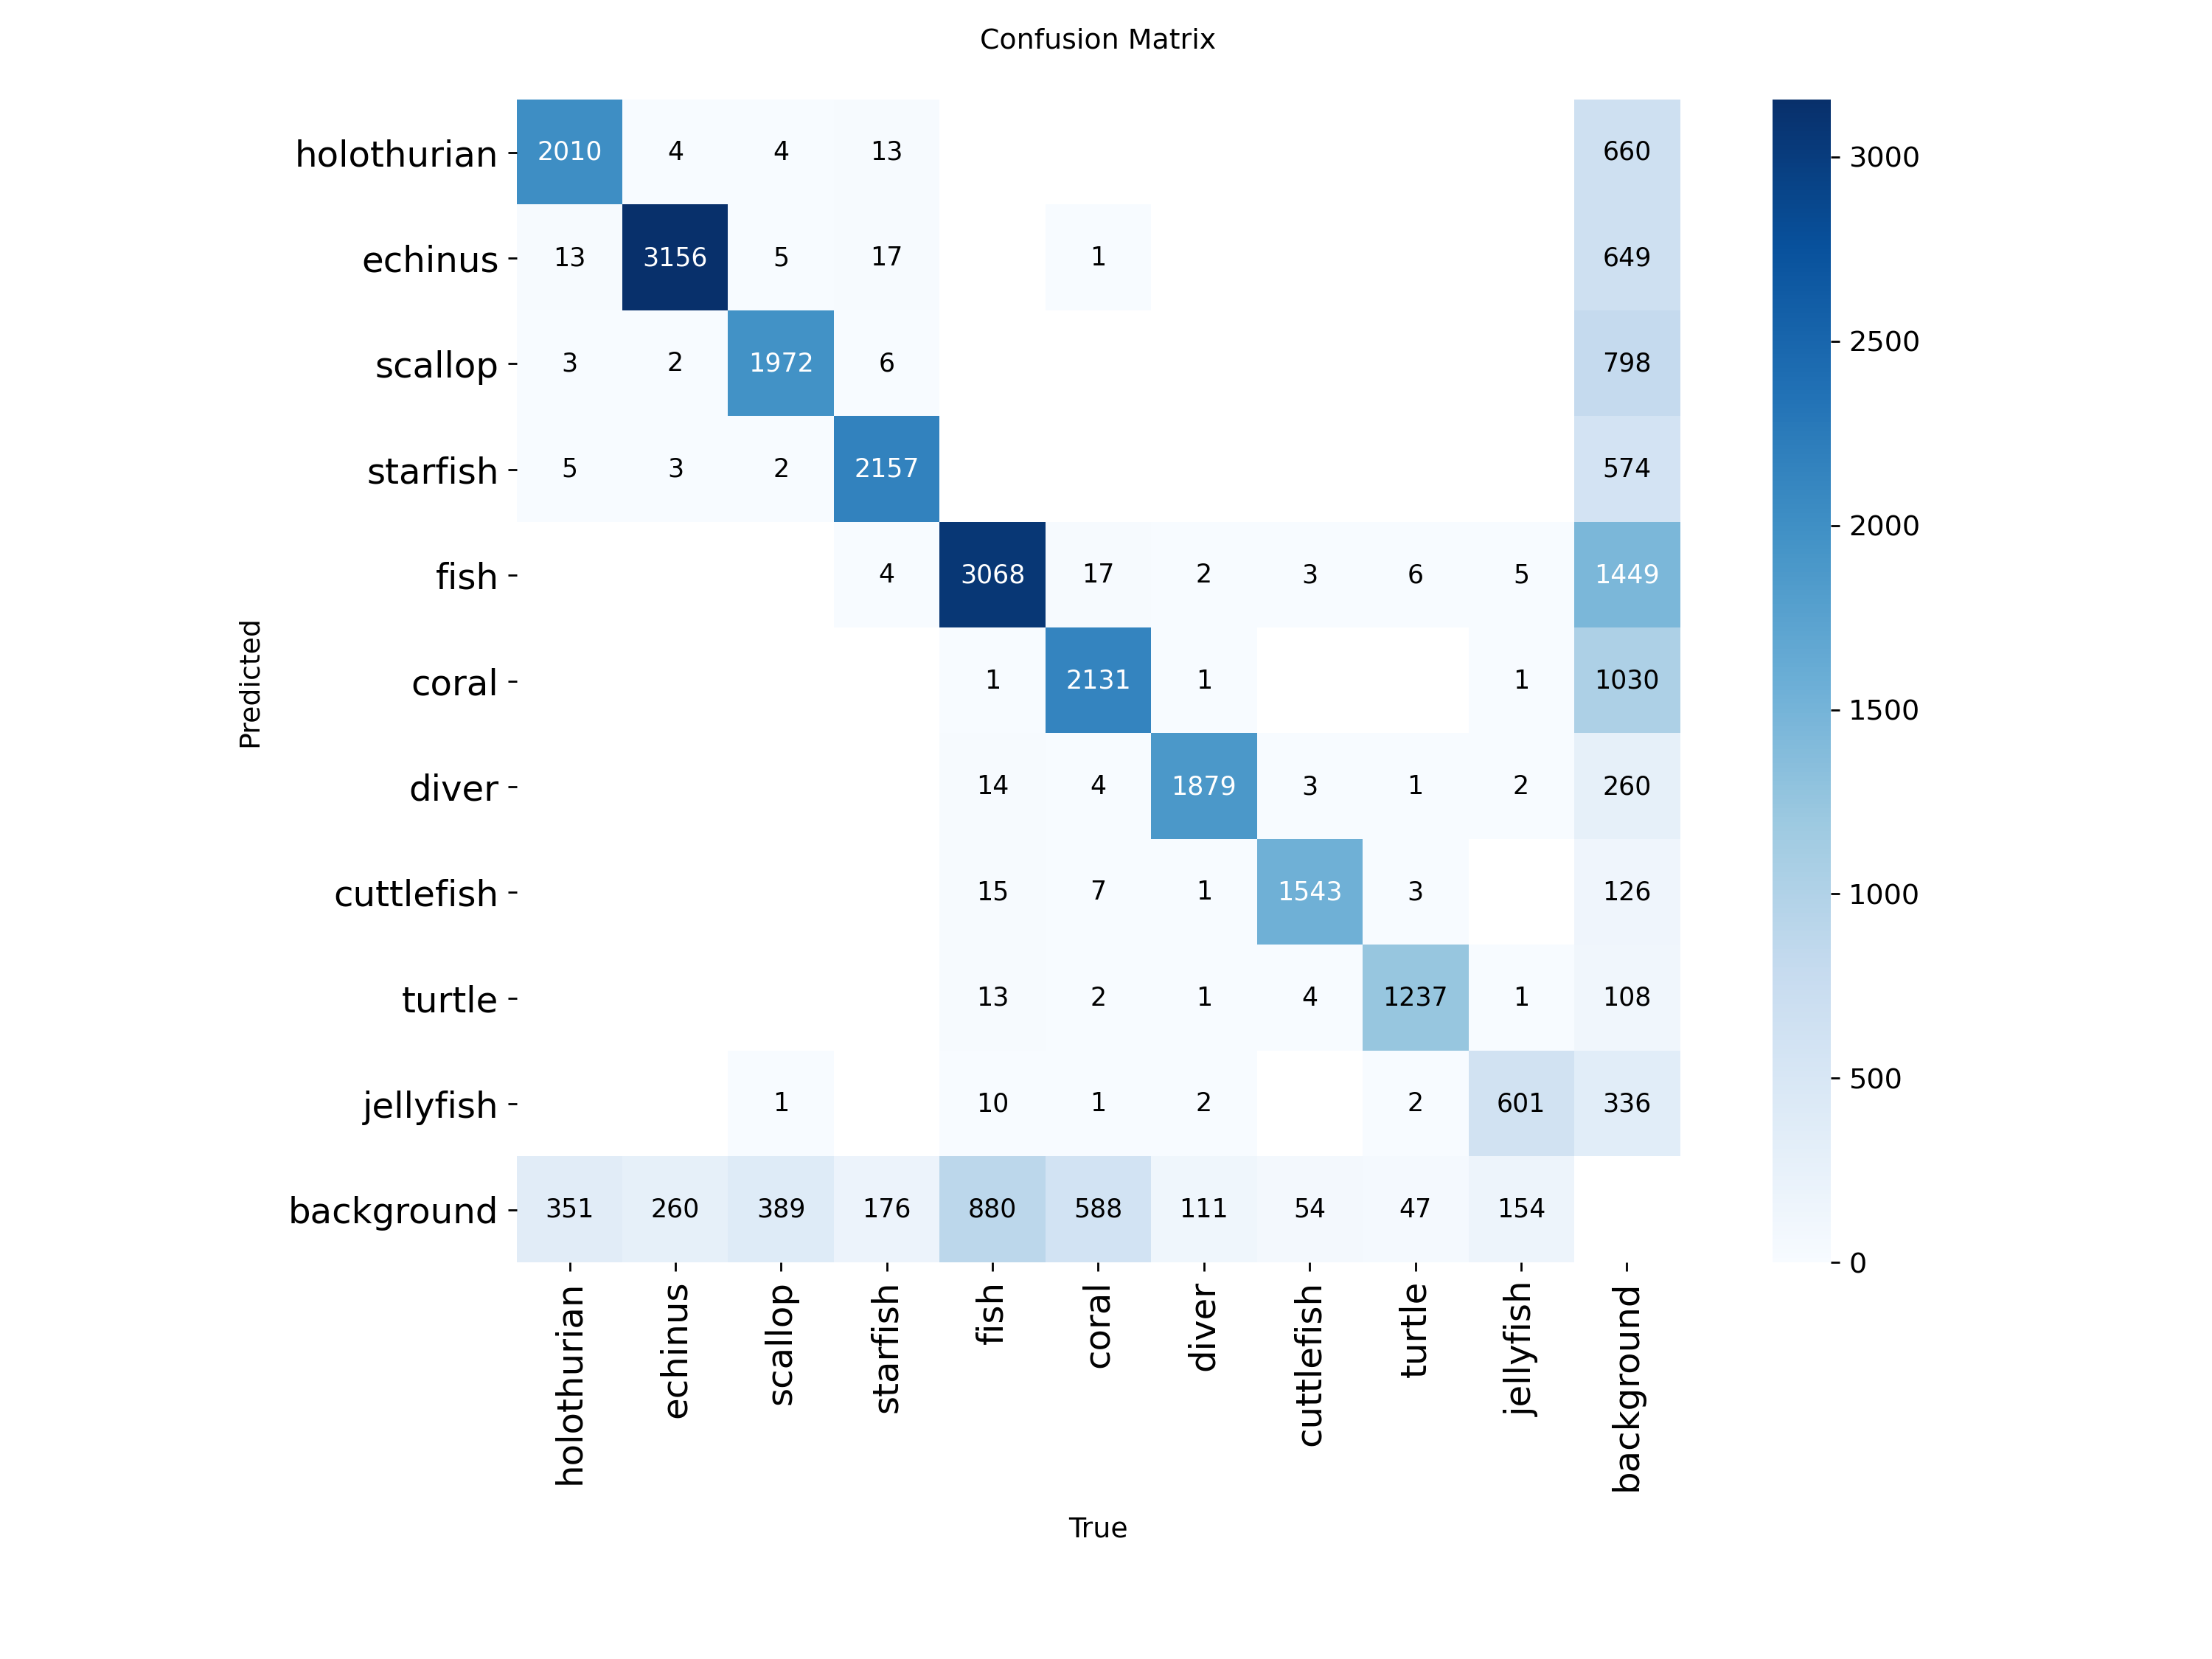

📈 confusion_matrix_normalized.png


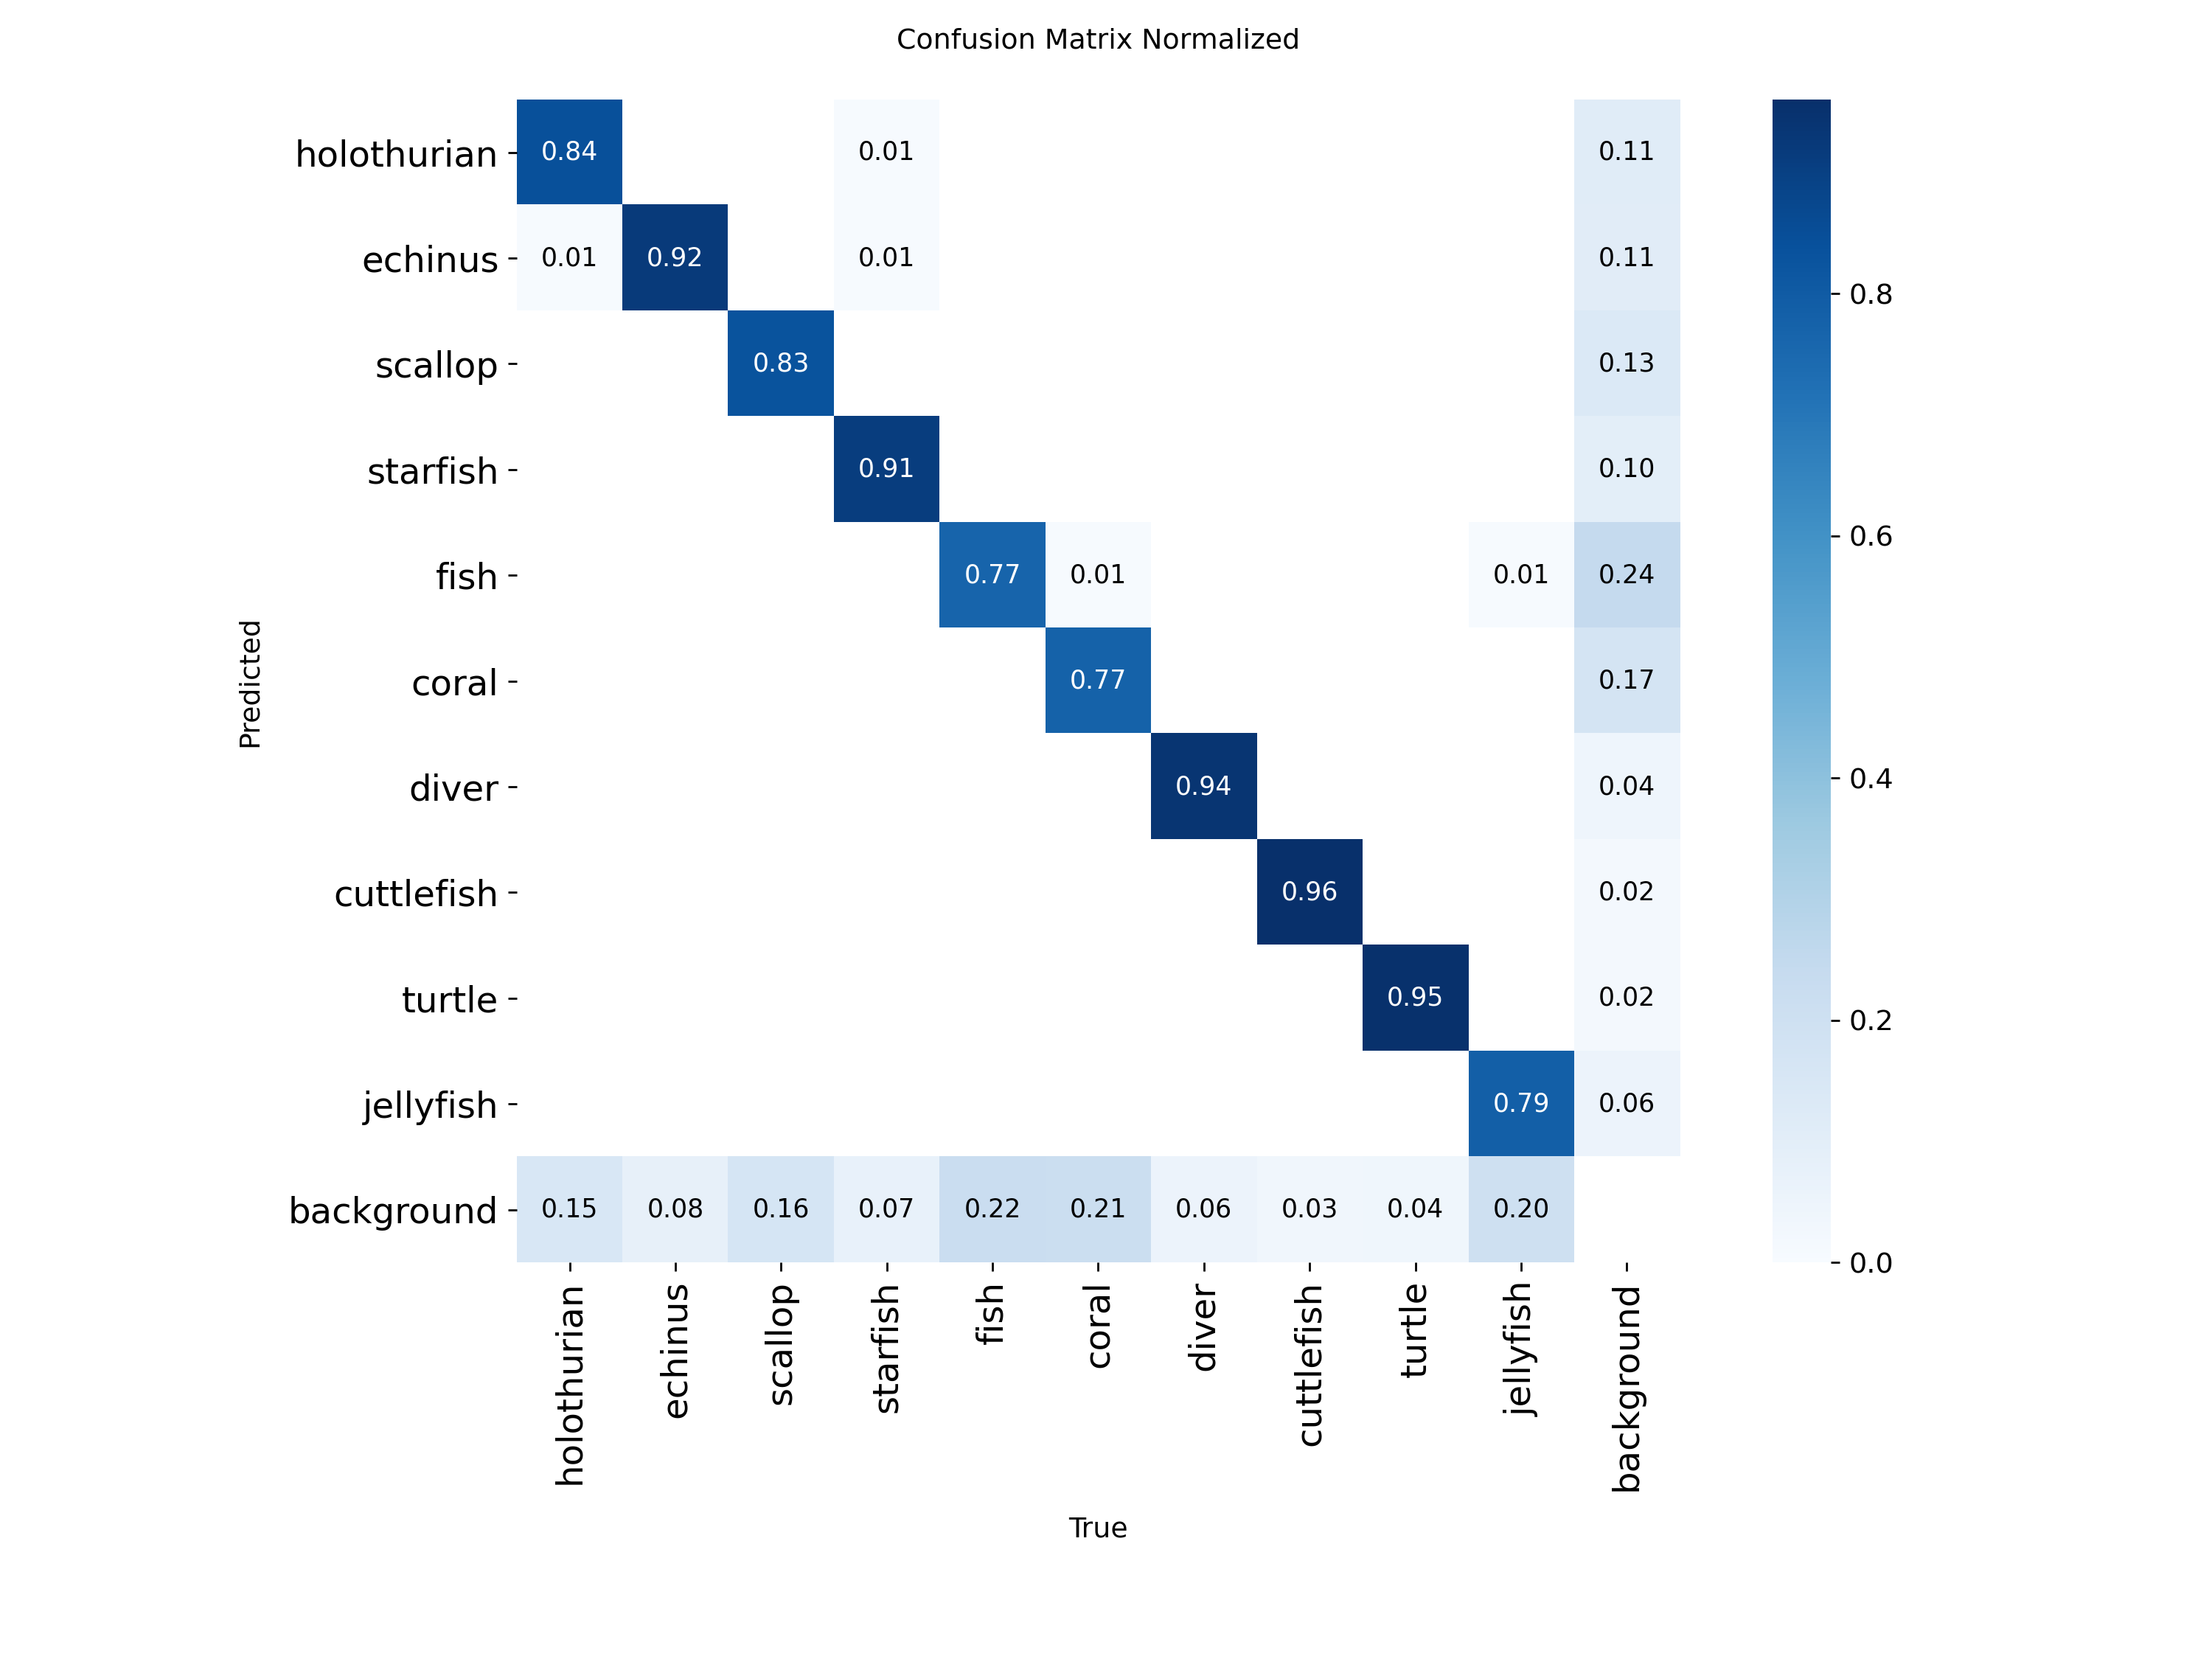

In [10]:
from IPython.display import display, Image, HTML
import os, glob

# 👉 change if you used a different name
run_dir = "runs_uwyolo/fasternet_eval"

# 1) Curves + confusion matrices
to_show = [
    "BoxPR_curve.png",      # PR curve (per class)
    "BoxP_curve.png",       # Precision vs conf
    "BoxR_curve.png",       # Recall vs conf
    "BoxF1_curve.png",      # F1 vs conf
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
]
for f in to_show:
    p = os.path.join(run_dir, f)
    if os.path.exists(p):
        print("📈", f)
        display(Image(filename=p))
    else:
        print("⚠️ missing:", p)




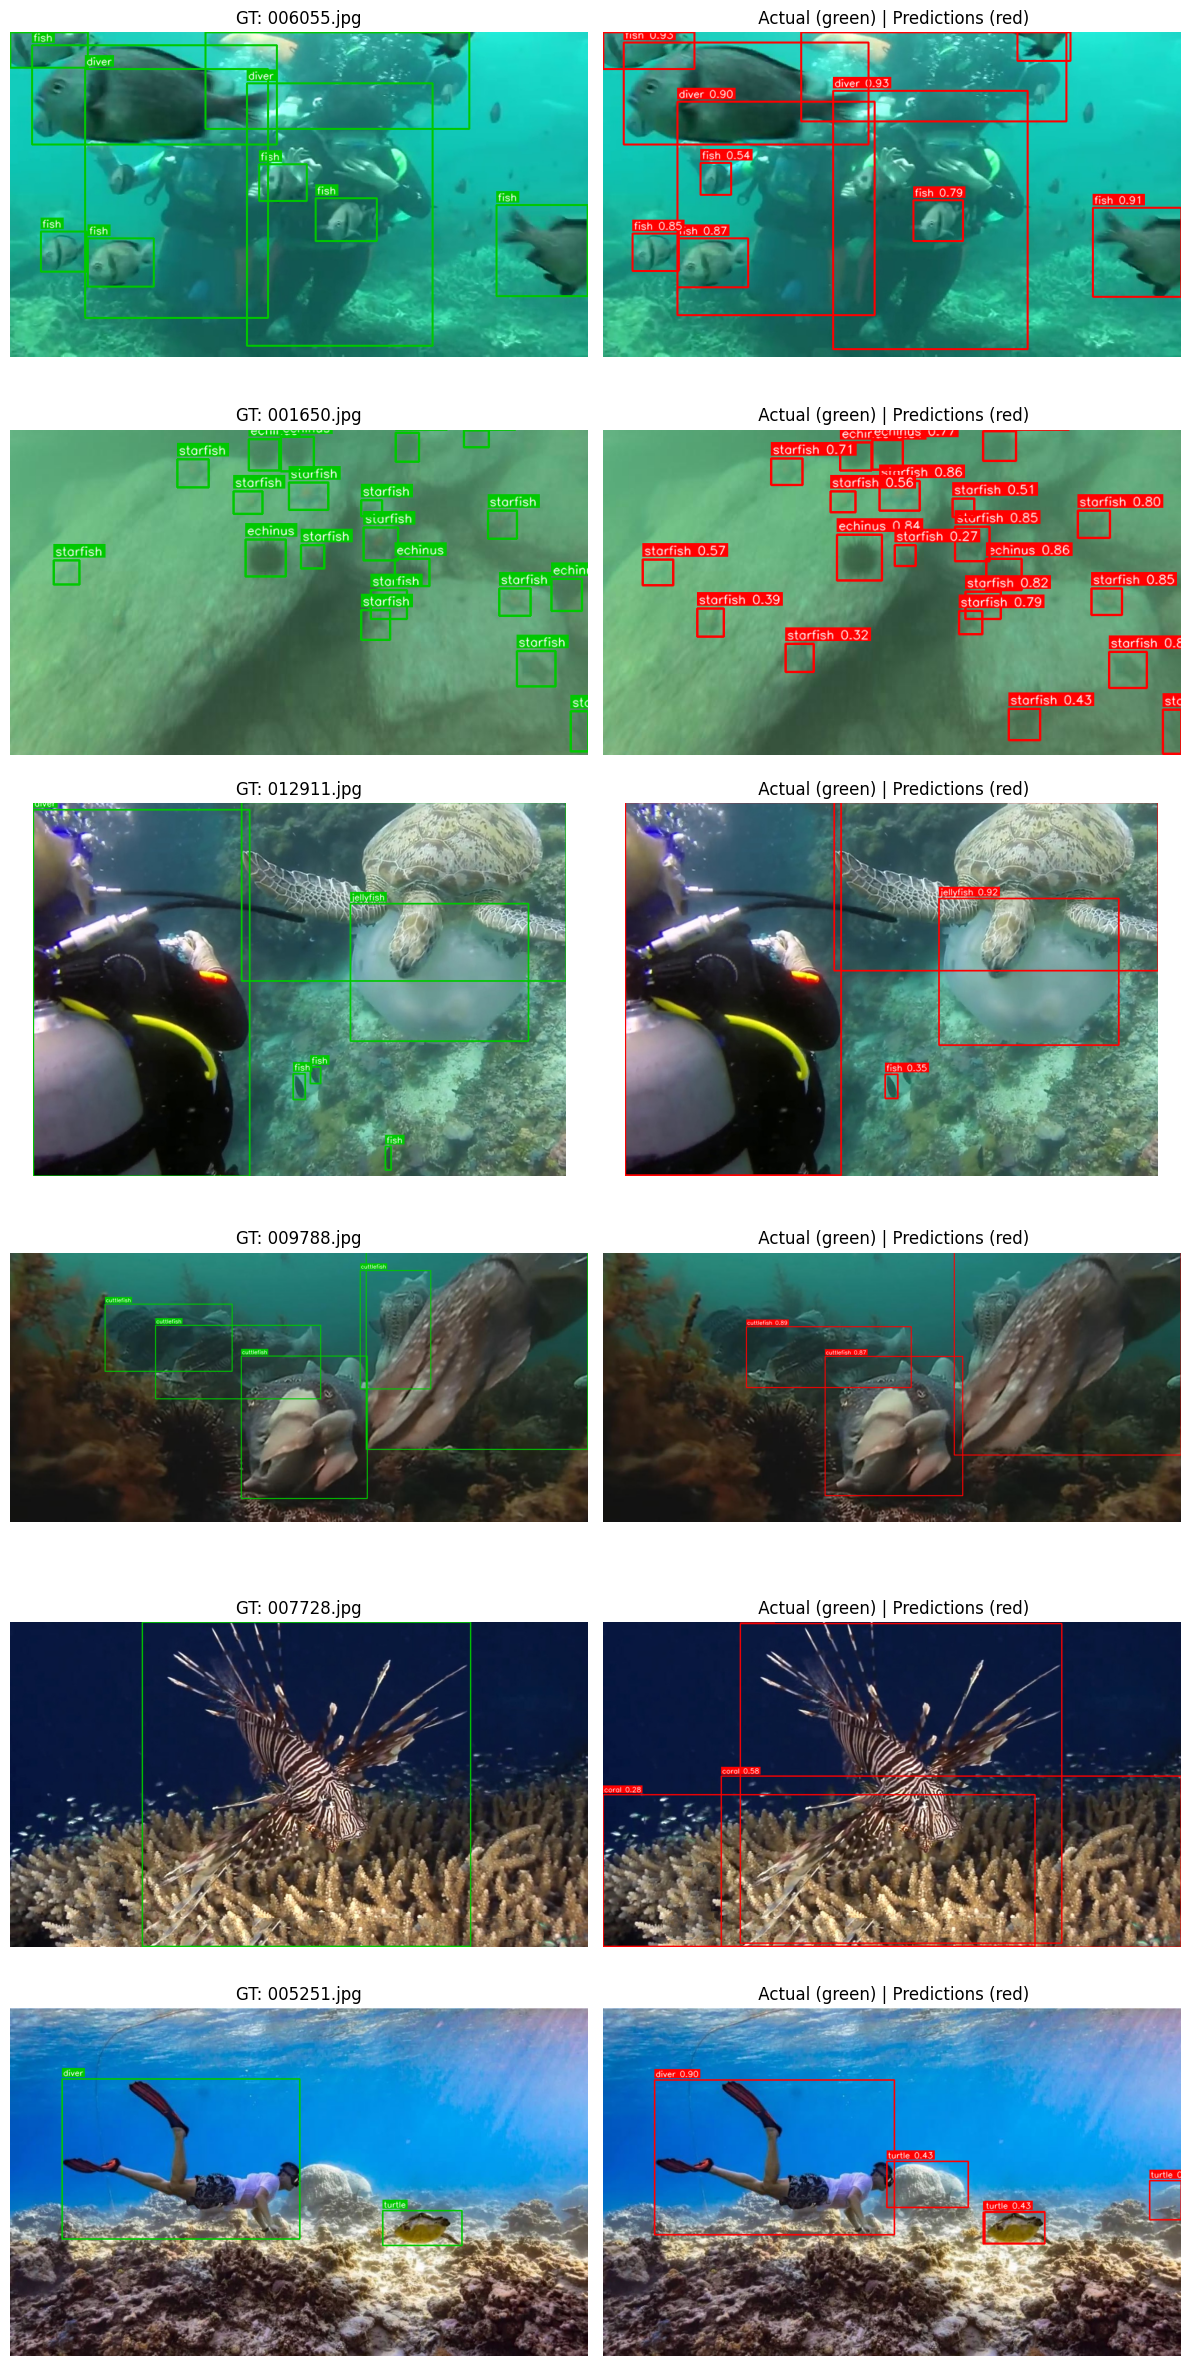

In [12]:
import cv2, random, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

# ---- Config ----
data_root = Path("data/RUOD")
images_dir = data_root / "images" / "test"   # change to 'train' if you want
labels_dir = data_root / "labels" / "test"
weights = "runs_uwyolo/fasternet_sgd300_4gpu_safe/weights/best.pt"

num_samples = 6      # how many random examples to show
conf_thres = 0.25    # prediction confidence threshold
imgsz = 640          # inference size

# ---- Load model ----
model = YOLO(weights)
names = model.names

# ---- Helpers ----
def yolo_txt_to_xyxy(txt_line, img_w, img_h):
    """Convert 'cls cx cy w h' (normalized) to xyxy pixel coords."""
    c, cx, cy, w, h = txt_line.strip().split()
    c = int(float(c))
    cx, cy, w, h = map(float, (cx, cy, w, h))
    x1 = (cx - w/2) * img_w
    y1 = (cy - h/2) * img_h
    x2 = (cx + w/2) * img_w
    y2 = (cy + h/2) * img_h
    return c, int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))

def draw_boxes(img, boxes, labels=None, color=(255, 0, 0), thickness=2):
    """Draw boxes [(x1,y1,x2,y2), ...] with optional label strings."""
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        if labels is not None:
            txt = labels[i]
            (tw, th), bl = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            ytxt = max(0, y1 - 4)
            cv2.rectangle(img, (x1, ytxt - th - 4), (x1 + tw + 4, ytxt), color, -1)
            cv2.putText(img, txt, (x1 + 2, ytxt - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return img

# ---- Collect images ----
image_paths = sorted([p for p in images_dir.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])
random.shuffle(image_paths)
image_paths = image_paths[:num_samples]

# ---- Inference + plot ----
cols = 2
rows = len(image_paths)
plt.figure(figsize=(12, 4 * rows))

for idx, img_path in enumerate(image_paths, 1):
    # Load image
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"⚠️ Could not read {img_path}")
        continue
    h, w = img_bgr.shape[:2]

    # --- Ground truth ---
    gt_boxes, gt_labels = [], []
    lbl_path = labels_dir / (img_path.stem + ".txt")
    if lbl_path.exists():
        with open(lbl_path, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                c, x1, y1, x2, y2 = yolo_txt_to_xyxy(line, w, h)
                gt_boxes.append((x1, y1, x2, y2))
                gt_labels.append(names.get(c, str(c)))
    gt_img = img_bgr.copy()
    gt_img = draw_boxes(gt_img, gt_boxes, gt_labels, color=(0, 200, 0), thickness=2)  # green for GT

    # --- Predictions ---
    # Run model; get per-image results
    res = model.predict(str(img_path), imgsz=imgsz, conf=conf_thres, verbose=False)[0]
    pred_boxes, pred_labels = [], []
    if res.boxes is not None and len(res.boxes) > 0:
        xyxy = res.boxes.xyxy.cpu().numpy().astype(int)
        cls  = res.boxes.cls.cpu().numpy().astype(int)
        conf = res.boxes.conf.cpu().numpy()
        for (x1, y1, x2, y2), c, p in zip(xyxy, cls, conf):
            pred_boxes.append((x1, y1, x2, y2))
            pred_labels.append(f"{names.get(c, str(c))} {p:.2f}")
    pred_img = img_bgr.copy()
    pred_img = draw_boxes(pred_img, pred_boxes, pred_labels, color=(0, 0, 255), thickness=2)  # red for Pred

    # --- Matplotlib show (convert BGR->RGB) ---
    gt_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    pr_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, 2*(idx-1)+1)
    plt.imshow(gt_rgb)
    plt.title(f"GT: {img_path.name}")
    plt.axis("off")

    plt.subplot(rows, cols, 2*(idx-1)+2)
    plt.imshow(pr_rgb)
    plt.title(" Actual (green) | Predictions (red)")
    plt.axis("off")

plt.tight_layout()
plt.show()
